I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import random
import math
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.stats as astats
import hepstats
from hepstats import *
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
from ciao_contrib.runtool import search_csc, obsid_search_csc
from sherpa.astro import ui
import bxa.sherpa as bxa

# CUSTOM Imports
from data_exploration_functions import *
from data_extraction_functions import *
from data_representation_functions import *

def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

II. Load Data

In [8]:
BEHR_DIR = '/Users/steven/Desktop/BBBB/BEHR'
DATA_DIR = '/Users/steven/Desktop/CSCData/23022need/'
evt_file = glob.glob(f'{DATA_DIR}*evt6*')[0]
regevt = glob.glob(f'{DATA_DIR}*evt6_filtered*')[0]
src_region = glob.glob(f'{DATA_DIR}*reg6*')[0]
bkg_region = glob.glob(f'{DATA_DIR}*bkg6*')[0]
bevt = glob.glob(f'{DATA_DIR}*evt6_back*')[0]

with fits.open(regevt) as hdul:
    # Events dataframe
    events = hdul["Events"].data
    events_table = Table(events)
    events_cols = events.columns.names
    df_events = pd.DataFrame.from_records(events_table, columns=events_cols)
    df_events = df_events.sort_values(by=["time"])
    # GTI (Good Time Interval) dataframe
    gti = hdul["GTI"].data
    gti_table = Table(gti)
    gti_cols = gti.columns.names
    df_gti = pd.DataFrame.from_records(gti_table, columns=gti_cols)
    # Apply GTI filter to events
    gti_mask = np.zeros(len(df_events), dtype=bool)
    for i in range(len(df_gti)):
        start = df_gti.iloc[i]['START']
        stop = df_gti.iloc[i]['STOP']
        gti_mask |= (df_events["time"] >= start) & (df_events["time"] < stop)
    df_events = df_events[gti_mask]
    # Apply energy, pha, grade filters to events
    df_events = df_events[(df_events['pha']>40) & (df_events['grade']>=0) & (df_events['energy']>500) & (df_events['energy']<7000)]
    start_time = min(df_events.time.values)
    src_times = df_events.time.values - start_time
    src_energies = df_events.energy.values

with fits.open(bevt) as hdul:
    # Events dataframe
    bevents = hdul["Events"].data
    bevents_table = Table(bevents)
    bevents_cols = bevents.columns.names
    df_bevents = pd.DataFrame.from_records(bevents_table, columns=bevents_cols)
    df_bevents = df_bevents.sort_values(by=["time"])
    # GTI (Good Time Interval) dataframe
    bgti = hdul["GTI"].data
    bgti_table = Table(bgti)
    bgti_cols = bgti.columns.names
    df_bgti = pd.DataFrame.from_records(bgti_table, columns=bgti_cols)
    # Apply GTI filter to events
    bgti_mask = np.zeros(len(df_bevents), dtype=bool)
    for i in range(len(df_bgti)):
        start = df_bgti.iloc[i]['START']
        stop = df_bgti.iloc[i]['STOP']
        bgti_mask |= (df_bevents["time"] >= start) & (df_bevents["time"] < stop)
    df_bevents = df_bevents[bgti_mask]
    # Apply energy, pha, grade filters to events
    df_bevents = df_bevents[(df_bevents['pha']>40) & (df_bevents['grade']>=0) & (df_bevents['energy']>500) & (df_bevents['energy']<7000)]
    bkg_times = df_bevents.time.values - start_time
    bkg_energies = df_bevents.energy.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


22634.12873506546
24122.964715480804


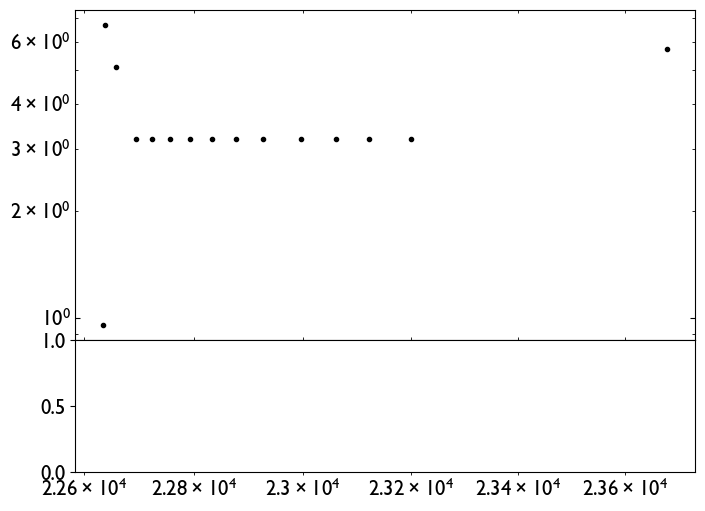

In [9]:
time = src_times[20:]
counts = np.ones(len(time))

mflux_con = 2.9013e-11

col = 'black'

import statistics

count_per_bin = 10
counts = np.ones(len(time))
num_bins = len(time) // count_per_bin
bb_bins = [time[i * count_per_bin] for i in range(num_bins)]
bb_bins.append(time[-1])
bb_bins = np.array(bb_bins)
time_bin = (bb_bins[:-1] + bb_bins[1:]) / 2
binned_counts, _ = np.histogram(time, bins=bb_bins, weights=counts)
time_bin_size = bb_bins[1] - bb_bins[0]
count_rate = binned_counts / time_bin_size

# binned_counts = [len(counts[i:i+bin_size]) for i in range(0, len(counts), bin_size)]
# time_stamps = [statistics.mean(time[i:i+bin_size]) for i in range(0, len(time)-bin_size+1, bin_size)]
# time_durations = [time[i+bin_size-1] - time[i] for i in range(0, len(time)-bin_size+1, bin_size)]
# count_rate = [count / duration for count, duration in zip(binned_counts, time_durations)]
# poisson_errors = [math.sqrt(c) for c in count_rate]

# binned_start_time = [time[i] for i in range(0, len(time), bin_size)]
# end_time_bins = [time[i+bin_size-1] for i in range(0, len(time)-bin_size+1, bin_size)]

# # Print the binned start time, number of bins, time stamp, time duration, and count rate for each bin
# for start_time, count, time_stamp, duration, rate in zip(binned_start_time, binned_counts, time_stamps, time_durations, count_rate):
#     print("Start Time: ", start_time)
#     print("Number of Bins: ", count)
#     print("Time Stamp: ", time_stamp)
#     print("Time Duration: ", duration)
#     print("Count Rate: ", rate)
#     print()


# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
# plt.xlabel('Energy [keV]')
# plt.ylabel('Count Rate [1/s/keV]')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6),gridspec_kw={'height_ratios': [5, 2]},sharex=True)

ax1.plot(time_bin,count_rate, color=col,linestyle='',marker='.')
ax1.set_yscale('log')
# ax1.set_ylim(0.01, 10)
ax2.set_xscale('log')
# ax2.set_xlim(10000, 100000)
ax1.tick_params(which='both', direction='in', top=True, right=True)
ax1.minorticks_on()
ax1.legend(loc='upper left', frameon=False, fontsize = 14)
# ax1.set_xlim([time[0],time[-1]])

print(time[0])
print(time[-1])
# # Add x-error bars as lines
# for x, y, yerr, xlo, xhi in zip(time_stamps, count_rate, poisson_errors, binned_start_time, end_time_bins):
#     ax1.errorbar(x, y, yerr=yerr, xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)

plt.subplots_adjust(hspace=0)
# plt.tight_layout()
plt.show()